# Example 5: Special functions

### Goal of this example

In this experiment, we use the KAN model to fit a function involving a special function:
$f(x,y)={\rm exp}(J_0(20x)+y^2)$
Where $J_0(x)$ is the zero-order Bessel function of the first kind. The purpose is to explore how well the KAN model can learn this function and recover the $J_0(x)$ structure.

**Objective**: Exploring how well the KAN model can learn special function and recover the $J_0(x)$ structure, therefore examining KAN's potential in the field of AI4Science.



## Step 1: Import Libraries and Define the target function

In [ ]:
from KANLayer import *
from MultKAN import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
# import torch
import numpy as np
import tensorflow as tf
from tensorkan.MultKAN import MultKAN as KANTF
from tensorkan.utils import *
from scipy.special import j0
from tensorkan.LBFGS import LBFGS

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

import tensorflow as tf

def target_function(x):
    """
    Target Function:
        f(x) = exp( J_0(20 * x_0) + x_1^2 )
    Args:
        x: Input TensorFlow tensor of shape (batch_size, 2)
    Returns:
        TensorFlow tensor of shape (batch_size, 1)
    """
    bessel_j0 = tf.numpy_function(j0, [20 * x[:, 0:1]], tf.float32)  # Using scipy.special.j0 for Bessel function
    square_term = tf.square(x[:, 1:2])
    result = tf.exp(bessel_j0 + square_term)
    return result


## Step 2: Build a Tensorflow KAN model and Start Training

In [37]:

model = KANTF(width=[2, 1, 1], grid=3, k=3, noise_scale=1.0)
f = lambda x: tf.math.exp(target_function(x))
dataset = create_dataset(f, n_var=2, train_num=1000)


model.fit(dataset, opt="LBFGS", steps=20, lamb=0.001, lr=0.001);


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.19e+01 | test_loss: 5.86e+01 | reg: 3.37e+02 |: 100%|█| 20/20 [00:43<00:00,  2.17s/i

Saving model version 0.1


## Step 3: Plot Trained KAN (the Bessel Function shows up in the bottom left)

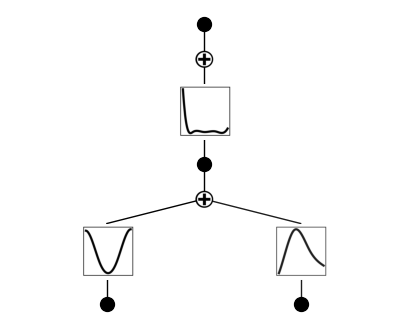

In [38]:
model.plot()

In [39]:
model = model.refine(1)
model.fit(dataset, opt="LBFGS", steps=10);

Saving model version 0.2


| train_loss: 3.86e+01 | test_loss: 6.77e+01 | reg: 6.38e+02 |: 100%|█| 10/10 [00:15<00:00,  1.60s/i

Saving model version 0.3


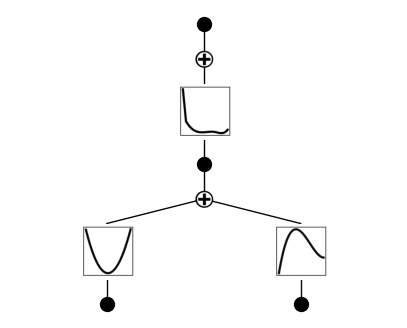

In [40]:
model.plot()

## Step 4: Add Bessel Function J0 to the Symbolic Library

Suggest_symbolic does not return anything that matches with it, since Bessel function isn't included in the default SYMBOLIC_LIB. We want to add Bessel to it.

In [41]:
model.suggest_symbolic(0,0,0)

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       x^2    0.999821 -12.369733           2                2   -0.873947
1       cos    0.999728 -11.792070           2                2   -0.758414
2       sin    0.998885  -9.795352           2                2   -0.359070
3         0    0.000000   0.000014           0                0    0.000003
4  gaussian    0.999584 -11.196676           3                3    0.160665


('x^2',
 (<function utils.<lambda>(x)>,
  <function utils.<lambda>(x)>,
  2,
  <function utils.<lambda>(x, y_th)>),
 0.99982107,
 2)

In [42]:
SYMBOLIC_LIB.keys()

dict_keys(['x', 'x^2', 'x^3', 'x^4', 'x^5', '1/x', '1/x^2', '1/x^3', '1/x^4', '1/x^5', 'sqrt', 'x^0.5', 'x^1.5', '1/sqrt(x)', '1/x^0.5', 'exp', 'log', 'abs', 'sin', 'cos', 'tan', 'tanh', 'sgn', 'arcsin', 'arccos', 'arctan', 'arctanh', '0', 'gaussian', 'J0'])

We define J0 by using tensorflow features.

In [43]:

def bessel_j0(x, terms=5):
    """
    Approximate calculation of the zero-order Bessel function of the first kind J_0(x).

    Args:
        x: TensorFlow tensor input (any shape).
        terms: Number of terms in the Taylor series expansion (default is 5).

    Returns:
        TensorFlow tensor representing the approximate value of J_0(x) for the input x.

    Explanation:
        J_0(x) is approximated using the Taylor series expansion:
        J_0(x) = 1 - (x^2 / 4) + (x^4 / 64) - (x^6 / 2304) + ...
        This implementation computes the expansion iteratively up to the specified number of terms.
    """
    result = tf.ones_like(x)  # Initialize result to 1
    power_x = tf.ones_like(x)  # Initialize x's power to 1 (for first term in the series)
    for n in range(1, terms):
        power_x *= -(x ** 2) / (4 * n ** 2)
        result += power_x
    return result

# Add the zero-order Bessel function J0 to the symbolic function library
add_symbolic('J0', bessel_j0, c=1)


After adding Bessel, we check suggest_symbolic again.

In [44]:
# J0 fitting is not very good
model.suggest_symbolic(0,0,0)

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       x^2    0.999821 -12.369733           2                2   -0.873947
1       cos    0.999728 -11.792070           2                2   -0.758414
2       sin    0.998885  -9.795352           2                2   -0.359070
3         0    0.000000   0.000014           0                0    0.000003
4  gaussian    0.999584 -11.196676           3                3    0.160665


('x^2',
 (<function utils.<lambda>(x)>,
  <function utils.<lambda>(x)>,
  2,
  <function utils.<lambda>(x, y_th)>),
 0.99982107,
 2)

## Step 5: Analysis of Results 

The fitting r2 is still not high, this is because the ground truth is \\( J_0(20x) \\) which involves 20 which is too large. our default search is in (-10,10). so we need to set the search range bigger in order to include 20. However, after testing for more rounds, the \\( J_0 \\) function still does not appear at the top. 

These are some possible reasons:

**Coefficient Range Issue**: The coefficient \\( 20 \\) in \\( J_0(20x) \\) exceeds the default search range \\((-10, 10)\\), making it difficult for the model to identify the correct structure.  
**Approximation Precision**: \\( J_0 \\) is not defined in tensorflow originally, so we need to use an approximation to get the function which is not accurate as it is in PyTorch. The custom \\( J_0 \\) implementation based on Taylor expansion may lack precision, especially for larger values like \\( 20x \\).  
**Data Inconsistency**: The target data is generated using `scipy.special.j0`, whereas training uses the approximated \\( J_0 \\), introducing discrepancies.  
**Model Bias Toward Simplicity**: The KAN model may inherently prioritize simpler functions over complex structures like \\( J_0 \\), even with an expanded search range.


In [45]:
model.suggest_symbolic(0,0,0,a_range=(-80,80))

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       sin    0.999821 -12.372466           2                2   -0.874493
1       x^2    0.999821 -12.371099           2                2   -0.874220
2       cos    0.999821 -12.369733           2                2   -0.873947
3         0    0.000000   0.000014           0                0    0.000003
4  gaussian    0.999678 -11.554985           3                3    0.089003


('sin',
 (<function utils.<lambda>(x)>,
  <function utils.<lambda>(x)>,
  2,
  <function utils.<lambda>(x, y_th)>),
 0.9998214,
 2)